# Intro

As part of my self-development, I wanted to rework a script, which are typically one-offs, and turn it into a reusable component, although there are existing packages for VaR. For those unfamiliar with VaR, it is an acronym for value at risk, the worst case loss in a period for a particular probability. This is currently a work in progress, a reworking of prior work with scripted VaR calculations, https://dataanalyticsworkouts.blogspot.com/2017/07/calculating-value-at-risk-var-with.html, implementing various high-level good practices, e.g., hiding/encapsulation, do-not-repeat-yourself (DRY), dependency injection, etc.

Features:

- Requires a data frame of stock returns, factor returns, and stock weights
- Exposes a method for calculating and returning VaR, for different variance types
- Exposes a method for calculating and returning an array of VaR values by confidence level
- Exposes a method for calculating and plotting an array of VaR values by confidence level

Still to do:

- Dynamic factor usage

Note: Data to validate this class is available from my Google Drive Public folder: https://drive.google.com/folderview?id=0B5Mi6_CV6da5aFc2Q0g3cHowVms&usp=sharing.


# Class

In [2]:
from  enum import Enum
class VaRType(Enum):
    Historical = 1
    Factor = 2
    Scenario = 3

class RiskCalculator(object):

    #################################
    # Class back-of-the-napkin
    # 
    # - Provide dataframe of stocks prices
    #
    # - Provide weights of stocks
    # -- Alt: Calculate weights
    #
    # - Provide dataframe of factor prices
    #
    # - Extracts stock names into data frame 
    # - Extract stock returns
    #
    # - Extracts factor names into data frame 
    # - Extract factor returns
    #
    # Historical
    # - Use weights and stock returns (no dates)
    #
    # Factor Model
    # - Use factors, stock names, returns
    # - create matrix of scenarios
    #
    # VaR
    # - for different risk types and confidence levels calculate VaR
    # - for different risk types and confidence levels calculate a range ofVaR
    # - for different risk types and confidence levels plot a range ofVaR
    #
    # To do
    # - dynamically build factor matrix
    # - Compare dates between stocks and factors
    # - Validate data
    # - Allow date range
    # - Auto-limit date range, with warning
    ###################################

    
    # Hiden Attributes
    __stockNames = []
    __factorNames = []
    __historicalRisk = 0
    __systemicVariance = 0
    __idiosyncraticVariance = 0
    __factorBasedVariance = 0
    __scenarioTotalVariance = 0
    __modelCoeffs = []

    
    #################################
    # Constructor
    #################################
    def __init__(self, stockReturns, factorReturns, weights):
        self.ChangeData(stockReturns, factorReturns, weights)

        
    #################################
    # Load data, sets and (re)calculates
    #################################
    def ChangeData(self, stockReturns, factorReturns, weights):        
        self.stockReturns = stockReturns
        self.factorReturns = factorReturns
        self.weights = weights
        RiskCalculator.__run()

        
    #################################
    # Run interrnal code
    #################################
    def __run():
        
        RiskCalculator.__extractNames()
        RiskCalculator.__calculateHistoricalVariance()
        RiskCalculator.__calculateHistoricalVariance()
        RiskCalculator.__buildFactorModel()
        RiskCalculator.__calculateFactorVariance()
        RiskCalculator.__calculateScenarioVariance()

        
    #################################
    # Extract names
    #################################
    def __extractNames():
        RiskCalculator.__stockNames = stockReturns.columns
        RiskCalculator.__factorNames = factorReturns.columns
    
    
    #################################
    # Estimating Historical Risk
    # cacluate portfolio variance
    # Var(p) = W * COV(Y) * W_transposed
    # matrix multiplication is done via np.dot
    # first is transpose of weights
    # second is the covariance of the returns
    # third is the matrix of weights
    #################################
    def __calculateHistoricalVariance():
        RiskCalculator.__historicalRisk = np.dot(np.dot(weights, stockReturns.cov()), weights.T)


    #################################
    # Building Factor Models
    # - Calculate lm (regression) for FVX, SP500, and the each stock
    #################################
    def __buildFactorModel():

        import statsmodels.api as sm

        # loops for each stock to create
        RiskCalculator.__modelCoeffs = []
        for stockName in RiskCalculator.__stockNames:
            stockReturn = returns[stockName]
            model = sm.OLS(stockReturn, factorReturns)
            result = model.fit()
            modelCoeffRow = list(result.params)
            modelCoeffRow.append(np.std(result.resid,ddof=1))
            RiskCalculator.__modelCoeffs.append(modelCoeffRow)
    
        # convert and cleanup data frame
        RiskCalculator.__modelCoeffs = pd.DataFrame(RiskCalculator.__modelCoeffs)
        RiskCalculator.__modelCoeffs.columns = ["B_FVX", "B_SP500",  "Alpha", "ResidualVol"]
        RiskCalculator.__modelCoeffs["Names"] = RiskCalculator.__stockNames

        
    #################################
    # Factor Analysis - Idiosyncratic and Systemic Risk
    # TotalVaR(P) = SystemicVaR(P) + IdisyncraticVaR(P)
    # SystemicVaR(P) = weights * betas * Cov(Factors) * betas_transposed * weights_transposed
    # idosyncraticVariance(P) = weights * var(residuals) * weight_transposed
    # totalVariance = systemicVariance + idiosyncraticVariance
    #################################
    def __calculateFactorVariance():

        # inner terms
        factorCovariance = factorReturns[["SP500","FVX"]].cov()
        reconstructedCov = (np.dot(np.dot(RiskCalculator.__modelCoeffs[["B_SP500", "B_FVX"]]
                                          ,factorCovariance),RiskCalculator.__modelCoeffs[["B_SP500", "B_FVX"]].T))
        # include outer terms
        RiskCalculator.__systemicVariance = np.dot(np.dot(weights, reconstructedCov), weights.T)

        RiskCalculator.__idiosyncraticVariance = sum(weights * RiskCalculator.__modelCoeffs["ResidualVol"] * weights * RiskCalculator.__modelCoeffs["ResidualVol"])

        RiskCalculator.__factorBasedVariance =  RiskCalculator.__systemicVariance +  RiskCalculator.__idiosyncraticVariance

        
    #################################
    # Scenario-based Stress Testing
    # create a range of scenarios, stepping from min to max for factors, FVX and S&P500
    # build scenarios from fvxScenarios by sp500Scenarios
    # set column names
    # totalVariance(P) = weights * cov(scenarios) * weight_transposed
    #################################
    def __calculateScenarioVariance():

        fvxScenarios = np.arange(min(returns["FVX"]), max(returns["FVX"]), .05)
        sp500Scenarios = np.arange(min(returns["SP500"]), max(returns["SP500"]), .02)

        scenarios = []
        for fvxValue in fvxScenarios:
            for sp500value in sp500Scenarios:
                scenario = [fvxValue, sp500value]
                for stockName in RiskCalculator.__stockNames:
                    alpha = float( RiskCalculator.__modelCoeffs[ RiskCalculator.__modelCoeffs["Names"] == stockName]["Alpha"])
                    beta_sp = float( RiskCalculator.__modelCoeffs[ RiskCalculator.__modelCoeffs["Names"] == stockName]["B_SP500"])
                    beta_fvx = float( RiskCalculator.__modelCoeffs[ RiskCalculator.__modelCoeffs["Names"] == stockName]["B_FVX"])
                    scenarioPredictedReturn = alpha + (beta_sp * sp500value) + (beta_fvx * fvxValue)
                    scenario.append(scenarioPredictedReturn)
                scenarios.append(scenario)

        scenarios = pd.DataFrame(scenarios)

        scenarios.columns = ["FVX","SP500","AAPL","ADBE","CVX","GOOG","IBM","MDLZ","MSFT","NFLX","ORCL","SBUX"]

        scenariosCov = scenarios[RiskCalculator.__stockNames].cov()
        RiskCalculator.__scenarioTotalVariance = np.dot(np.dot(weights, scenariosCov), weights.T)


    #################################
    # Simple VaR calculator
    # VaR = P x Z_alpha x stdDev
    #################################
    def __calculateVaR(risk, percentile, principal = 1, numMonths = 1):

        import math
        import scipy.stats as st

        vol = math.sqrt(risk)
        return abs(principal * st.norm.ppf(1-percentile, 0, 1) * vol * math.sqrt(numMonths))
    
    
    #################################
    # Returns the instance value of the risk type
    #################################
    def __getRiskByType(varType):
                
        if varType == VaRType.Historical:
            varianceType = RiskCalculator.__historicalRisk
        elif varType == VaRType.Factor:
            varianceType = RiskCalculator.__factorBasedVariance
        elif varType == VaRType.Scenario:
            varianceType = RiskCalculator.__scenarioTotalVariance

        return varianceType
        
        
    #################################
    # Exposed calculator
    #################################
    def GetVaR(self, varType = VaRType.Historical, percentile = 0.99):

        # Type checking
        if not isinstance(varType, VaRType):
            raise TypeError('vaRType must be an instance of VaRType Enum')
        
        varianceType = RiskCalculator.__getRiskByType(varType)

        return RiskCalculator.__calculateVaR(varianceType, percentile)
        
        
    #################################
    # Exposed range calcualtor
    #################################
    def GetVaRRange(self, varType = VaRType.Historical, minPercentile = 0.90, maxPercentile = 0.995, step = 0.01):

        return RiskCalculator.__getVaRRange(varType, minPercentile, maxPercentile, step)
        

    #################################
    # Range calcualtor
    #################################
    def __getVaRRange(varType = VaRType.Historical, minPercentile = 0.90, maxPercentile = 0.995, step = 0.01):

        # Type checking
        if not isinstance(varType, VaRType):
            raise TypeError('varType must be an instance of VaRType Enum')
        
        varianceType = RiskCalculator.__getRiskByType(varType)

        import numpy as np
        stepValues = np.arange(minPercentile, maxPercentile, step) 
        
        # loops for each stock to create
        riskArray = []
        for stepValue in range(0, len(stepValues), 1):
            percentile = stepValues[stepValue]
            riskVal = RiskCalculator.__calculateVaR(varianceType, percentile)
            riskRow = [percentile, riskVal]
            riskArray.append(riskRow)
            
        import pandas as pd
        riskArray = pd.DataFrame(riskArray)
        riskArray.columns = ["Confidence","VaR"]

        return riskArray

    
    #################################
    # Exposed range calcualtor
    #################################
    def PlotVaRRange(self, varType = VaRType.Historical, minPercentile = 0.90, maxPercentile = 0.995, step = 0.01):

        varArray = RiskCalculator.__getVaRRange(varType, minPercentile, maxPercentile, step)

        import matplotlib.pyplot as plt
        plt.plot(varArray["Confidence"],varArray["VaR"])
        plt.show()


# Use Class

## Import and Clean

In [3]:

import pandas as pd

# Get data
portfolios = pd.read_csv("Portfolios.csv", sep=",")

# format date
portfolios['AsOfDate'] = pd.to_datetime(portfolios['AsOfDate'], format='%m/%d/%Y', yearfirst = True)

# sort by date
portfolios = portfolios.sort_values(['AsOfDate'] , ascending=True)


## Create Data Frames for Class Initialization

In [4]:

import numpy as np

# calculate returns
returns = portfolios[[ key for key in dict(portfolios.dtypes) if dict(portfolios.dtypes)[key] in [ 'float64', 'int64']]].pct_change()
returns = returns[1:]

# add intercept column
returns['Intercept'] = 1

# create lists of names to easily filter returns
stockNames = list(returns)[0:10]
factorNames = list(returns)[10:13]

# set values for returns and weights
stockReturns = returns[stockNames]
factorReturns = returns[factorNames]
weights = np.array([1.0/len(stockNames)]*len(stockNames))


# Display VaR Measures

## Create and Run Class

In [5]:

test = RiskCalculator(stockReturns, factorReturns, weights)


## Display Results

## Get VaR

In [6]:

test.GetVaR(VaRType.Historical, 0.99)


0.11978443009308773

In [7]:

test.GetVaR(VaRType.Factor, 0.99)


0.11676976342787514

In [8]:

test.GetVaR(VaRType.Scenario, 0.99)


0.18423912870376541

## Get a Range of VaR

In [9]:

test.GetVaRRange(VaRType.Historical, 0.90, 0.995, 0.01)


,Confidence,VaR
0,0.90,0.065988
1,0.91,0.069036
2,0.92,0.072348
3,0.93,0.075989
4,0.94,0.080056
5,0.95,0.084694
6,0.96,0.090143
7,0.97,0.096843
8,0.98,0.105748
9,0.99,0.119784


In [10]:

test.GetVaRRange(VaRType.Factor, 0.90, 0.995, 0.01)


,Confidence,VaR
0,0.90,0.064327
1,0.91,0.067298
2,0.92,0.070527
3,0.93,0.074077
4,0.94,0.078041
5,0.95,0.082563
6,0.96,0.087875
7,0.97,0.094405
8,0.98,0.103087
9,0.99,0.116770


In [11]:

test.GetVaRRange(VaRType.Scenario, 0.90, 0.995, 0.01)


,Confidence,VaR
0,0.90,0.101495
1,0.91,0.106183
2,0.92,0.111277
3,0.93,0.116878
4,0.94,0.123133
5,0.95,0.130267
6,0.96,0.138649
7,0.97,0.148953
8,0.98,0.162650
9,0.99,0.184239


## Plot VaR

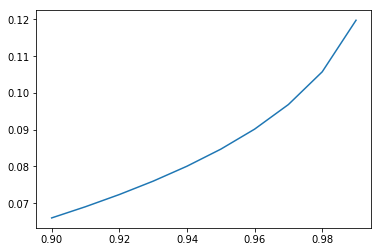

In [12]:

test.PlotVaRRange(VaRType.Historical, 0.90, 0.991, 0.01)


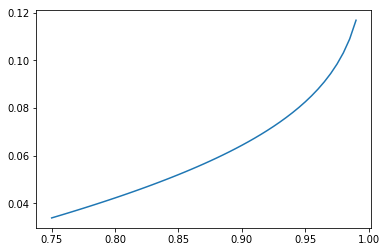

In [13]:

test.PlotVaRRange(VaRType.Factor, 0.75, 0.991, 0.005)


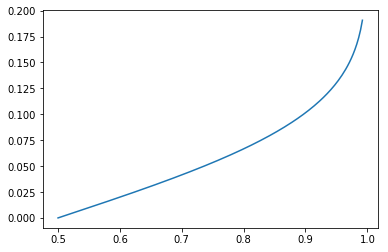

In [14]:

test.PlotVaRRange(VaRType.Scenario, 0.5, 0.995, 0.003)
